DATASET LINK: https://www.kaggle.com/datasets/zaraks/pascal-voc-2007

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
from collections import defaultdict
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import random


In [ ]:
import torchvision.transforms as T
import torchvision
import torch
from torch.utils.data import DataLoader

# Define dataset path and vehicle classes
dataset_path = './data/VOC'
vehicle_classes = ['car', 'truck', 'bus', 'motorbike']

# Define a transformation to convert images to tensors
transform = T.Compose([T.ToTensor()])

# Load the Pascal VOC dataset with transformations for the images
train_dataset = torchvision.datasets.VOCDetection(
    root=dataset_path,
    year='2007',
    image_set='train',
    download=True,
    transforms=lambda img, target: (transform(img), target)  # Apply transform to images
)

# Filter and prepare the dataset to include only specified vehicle classes
def filter_and_prepare_vehicle_classes(dataset):
    filtered_data = []
    for img, target in dataset:
        annotations = target['annotation']['object']
        filtered_annotations = [
            obj for obj in annotations if obj['name'] in vehicle_classes
        ]
        if not filtered_annotations:
            continue

        # Prepare targets for Faster R-CNN
        boxes = []
        labels = []
        for obj in filtered_annotations:
            # Bounding box coordinates (xmin, ymin, xmax, ymax)
            bndbox = obj['bndbox']
            box = [int(bndbox['xmin']), int(bndbox['ymin']), int(bndbox['xmax']), int(bndbox['ymax'])]

            boxes.append(box)
            labels.append(vehicle_classes.index(obj['name']) + 1)  # Convert class name to index

        # Convert boxes to float tensors and labels to int64 tensors
        target_data = {
           'boxes': torch.FloatTensor(boxes),
           'labels': torch.IntTensor(labels).to(torch.int64)  # Ensure labels are int64
        }

        filtered_data.append((img, target_data))

    return filtered_data

train_dataset = filter_and_prepare_vehicle_classes(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))



100%|██████████| 460M/460M [00:18<00:00, 24.8MB/s]


Extracting ./data/VOC/VOCtrainval_06-Nov-2007.tar to ./data/VOC


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
#Reduced Parameters
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define the model
def get_vehicle_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = len(vehicle_classes) + 1
model = get_vehicle_detection_model(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Adjusted training parameters for slower learning
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.85, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

num_epochs = 5  # Reduced epochs for faster experimentation
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting epoch {epoch + 1}/{num_epochs}")
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

torch.save(model.state_dict(), 'vehicle_detection_model_reduced_params.pth')


Starting epoch 1/5


<ipython-input-4-4e1b85a76843>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Starting epoch 2/5
Starting epoch 3/5
Starting epoch 4/5
Starting epoch 5/5


In [ ]:
#Increased Parameter
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define the model
def get_vehicle_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = len(vehicle_classes) + 1
model = get_vehicle_detection_model(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Adjusted training parameters for faster learning
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.95, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

num_epochs = 15  # Increased epochs for more training time
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting epoch {epoch + 1}/{num_epochs}")
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

torch.save(model.state_dict(), 'vehicle_detection_model_increased_params.pth')


In [ ]:
# Define the model
def get_vehicle_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = len(vehicle_classes) + 1
model = get_vehicle_detection_model(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Train the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting epoch {epoch + 1}/{num_epochs}")
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

torch.save(model.state_dict(), 'vehicle_detection_model.pth')


Starting epoch 1/10


<ipython-input-4-27660b7f874e>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


Starting epoch 2/10
Starting epoch 3/10
Starting epoch 4/10
Starting epoch 5/10
Starting epoch 6/10
Starting epoch 7/10
Starting epoch 8/10
Starting epoch 9/10
Starting epoch 10/10


In [ ]:
# Reload model for inference
model = get_vehicle_detection_model(num_classes)
model.load_state_dict(torch.load('vehicle_detection_model_reduced_params.pth'))
model.to(device)
model.eval()

# Function to process each frame of video and display detections
# Define a color mapping for each vehicle class if not defined in another cell
color_mapping = {
    'car': (0, 0, 255),       # Red
    'truck': (255, 0, 0),     # Blue
    'bus': (0, 255, 0),       # Green
    'motorbike': (0, 255, 255) # Yellow
}

# Modify the process_frame function
def process_frame(frame):
    transform = transforms.ToTensor()
    frame_tensor = transform(frame).unsqueeze(0).to(device)

    # Run model inference
    with torch.no_grad():
        predictions = model(frame_tensor)

    # Count and draw detections
    frame_vehicle_count = defaultdict(int)
    for i, label in enumerate(predictions[0]['labels']):
        score = predictions[0]['scores'][i]
        if score > 0.5:
            x1, y1, x2, y2 = predictions[0]['boxes'][i].cpu().numpy().astype(int)
            vehicle_type = vehicle_classes[label.item() - 1]
            frame_vehicle_count[vehicle_type] += 1

            # Get the color for the specific vehicle class
            color = color_mapping.get(vehicle_type, (0, 255, 0))

            # Draw bounding box with specific color
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            # Display class name and confidence score
            text = f"{vehicle_type} {score:.2f}"  # Format text to include name and score
            cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return frame, frame_vehicle_count


<ipython-input-8-2758d0053b00>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vehicle_detection_model_reduced_params.pth'))


In [ ]:
def process_video(input_path, output_path):
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Set up video writer with additional space for frame count display
    frame_count_height = 30
    total_height = height + frame_count_height
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, total_height))

    frame_number = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process each frame
        frame, frame_vehicle_count = process_frame(frame)

        # Create a black strip at the bottom for frame count
        frame_with_count = np.zeros((total_height, width, 3), dtype=np.uint8)
        frame_with_count[:height, :] = frame

        # Display frame count on the black strip
        frame_number += 1
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        font_scale = 0.8
        font_thickness = 1
        text = f"Frame: {frame_number}"
        text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
        text_x = (width - text_size[0]) // 2
        text_y = height + (frame_count_height + text_size[1]) // 2
        cv2.putText(frame_with_count, text, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)

        # Write the frame with bounding boxes to output
        from google.colab.patches import cv2_imshow
        out.write(frame_with_count)
        cv2_imshow(frame_with_count)
        print("Vehicle count in frame:", frame_vehicle_count)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()


In [ ]:
process_video('/content/input_video.mp4', 'output_video.mp4')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this be

Accuracy: 0.9003
Precision: 0.8999
Recall: 0.9003
F1 Score: 0.9000


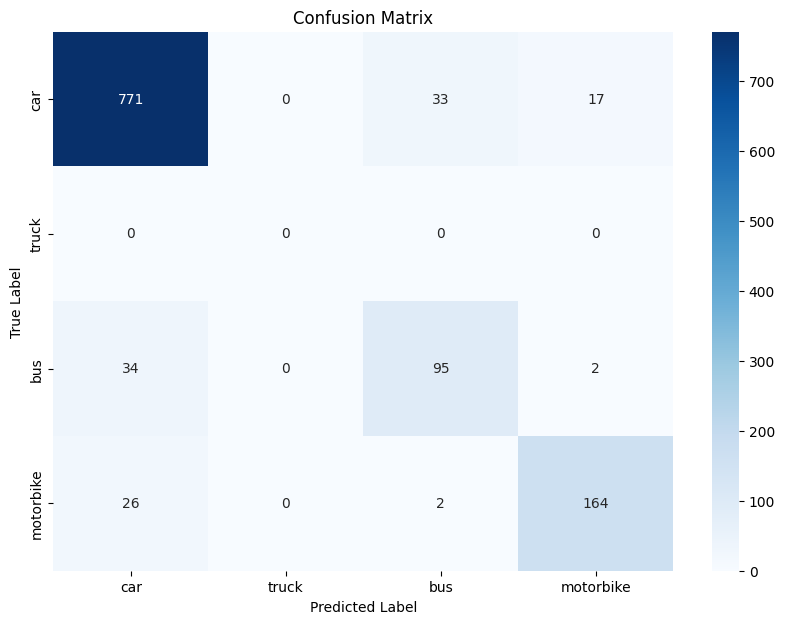

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader, iou_threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                # Predicted labels
                pred_labels = output['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()

                # Ground truth labels
                target_labels = targets[i]['labels'].cpu().numpy()

                # Filter predictions by confidence score (e.g., > 0.5)
                high_conf_indices = pred_scores >= 0.5
                pred_labels = pred_labels[high_conf_indices]

                # Ensure the true and predicted labels have the same length for evaluation
                min_len = min(len(pred_labels), len(target_labels))
                all_pred_labels.extend(pred_labels[:min_len])
                all_true_labels.extend(target_labels[:min_len])

    # Convert to class names
    true_labels = [vehicle_classes[label - 1] for label in all_true_labels]
    pred_labels = [vehicle_classes[label - 1] for label in all_pred_labels]

    # Confusion matrix and metrics
    cm = confusion_matrix(true_labels, pred_labels, labels=vehicle_classes)
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, labels=vehicle_classes, average='weighted')
    recall = recall_score(true_labels, pred_labels, labels=vehicle_classes, average='weighted')
    f1 = f1_score(true_labels, pred_labels, labels=vehicle_classes, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=vehicle_classes, yticklabels=vehicle_classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model after training
evaluate_model(model, train_loader)  # Or use validation_loader if available
